## 1. Importing Libraries

In [1]:
# Data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For displaying full tables
pd.set_option('display.max_columns', None)

## 2. Loading and Merging Datasets
### 2.1. Load Only Necessary Columns

In [2]:
# Define the columns to load for each dataset
transactions_cols = ['id', 'date', 'client_id', 'card_id', 'amount']
cards_cols = ['id', 'client_id', 'credit_limit', 'card_brand', 'card_type']
users_cols = ['id', 'current_age', 'gender']

# Load datasets with selected columns
transactions_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/transactions_data.csv', usecols=transactions_cols)
cards_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/cards_data.csv', usecols=cards_cols)
users_df = pd.read_csv('/kaggle/input/transactions-fraud-datasets/users_data.csv', usecols=users_cols)

### 2.2. Inspect Datasets

In [3]:
print('Transactions DataFrame:')
transactions_df.head()

Transactions DataFrame:


,id,date,client_id,card_id,amount
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00
1,7475328,2010-01-01 00:02:00,561,4575,$14.57
2,7475329,2010-01-01 00:02:00,1129,102,$80.00
3,7475331,2010-01-01 00:05:00,430,2860,$200.00
4,7475332,2010-01-01 00:06:00,848,3915,$46.41


In [4]:
print('\nUsers DataFrame:')
users_df.head()


Users DataFrame:


,id,current_age,gender
0,825,53,Female
1,1746,53,Female
2,1718,81,Female
3,708,63,Female
4,1164,43,Male


In [5]:


print('\nCards DataFrame:')
cards_df.head()


Cards DataFrame:


,id,client_id,card_brand,card_type,credit_limit
0,4524,825,Visa,Debit,$24295
1,2731,825,Visa,Debit,$21968
2,3701,825,Visa,Debit,$46414
3,42,825,Visa,Credit,$12400
4,4659,825,Mastercard,Debit (Prepaid),$28


## 3. Data Preprocessing
### 3.1. Optimize Data Types
Optimize data types to reduce memory usage.

In [6]:
# Optimize 'transactions_df'
transactions_df['amount'] = transactions_df['amount'].replace('[\$,]', '', regex=True).astype(float)
transactions_df['client_id'] = pd.to_numeric(transactions_df['client_id'], downcast='unsigned')
transactions_df['card_id'] = pd.to_numeric(transactions_df['card_id'], downcast='unsigned')
transactions_df['id'] = pd.to_numeric(transactions_df['id'], downcast='unsigned')
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Optimize 'cards_df'
cards_df['credit_limit'] = cards_df['credit_limit'].replace('[\$,]', '', regex=True).astype(float)
cards_df['client_id'] = pd.to_numeric(cards_df['client_id'], downcast='unsigned')
cards_df['id'] = pd.to_numeric(cards_df['id'], downcast='unsigned')

# Optimize 'users_df'
users_df['id'] = pd.to_numeric(users_df['id'], downcast='unsigned')
users_df['current_age'] = pd.to_numeric(users_df['current_age'], downcast='unsigned')

### 3.1 Convert Categorical Variables to 'category' Data Type
This helps to reduce memory usage significantly.

In [7]:
# For 'transactions_df', if there are any categorical variables you need to optimize
# For this case, 'transactions_df' has no categorical variables in selected columns

# For 'cards_df'
cards_df['card_brand'] = cards_df['card_brand'].astype('category')
cards_df['card_type'] = cards_df['card_type'].astype('category')

# For 'users_df'
users_df['gender'] = users_df['gender'].astype('category')

### 3.2 Handle Missing Values
Check and handle missing values appropriately.

In [8]:
# Check for missing values in 'transactions_df'
print('Missing values in transactions_df:\n', transactions_df.isnull().sum())

# Drop rows with missing 'amount' or 'date' in 'transactions_df'
transactions_df.dropna(subset=['amount', 'date'], inplace=True)

# For 'cards_df', handle missing 'credit_limit' if any
cards_df['credit_limit'].fillna(cards_df['credit_limit'].median(), inplace=True)

# For 'users_df', handle missing 'current_age' if any
users_df['current_age'].fillna(users_df['current_age'].median(), inplace=True)

Missing values in transactions_df:
 id           0
date         0
client_id    0
card_id      0
amount       0
dtype: int64


### Merging Datasets
Merge the datasets to create a comprehensive DataFrame for analysis.

In [9]:
# Merge transactions with cards on 'card_id' and 'id'
transactions_cards_df = transactions_df.merge(
    cards_df,
    how='left',
    left_on='card_id',
    right_on='id',
    suffixes=('', '_card')
)

# Drop redundant 'id_card' column
transactions_cards_df.drop('id_card', axis=1, inplace=True)

# Merge the result with users on 'client_id' and 'id'
transactions_full_df = transactions_cards_df.merge(
    users_df,
    how='left',
    left_on='client_id',
    right_on='id',
    suffixes=('', '_user')
)

# Drop redundant 'id_user' column
transactions_full_df.drop('id_user', axis=1, inplace=True)

In [10]:
transactions_full_df.head()

,id,date,client_id,card_id,amount,client_id_card,card_brand,card_type,credit_limit,current_age,gender
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,1556,Mastercard,Debit (Prepaid),55.0,30,Female
1,7475328,2010-01-01 00:02:00,561,4575,14.57,561,Mastercard,Credit,9100.0,48,Male
2,7475329,2010-01-01 00:02:00,1129,102,80.00,1129,Mastercard,Debit,14802.0,49,Male
3,7475331,2010-01-01 00:05:00,430,2860,200.00,430,Mastercard,Debit,37634.0,52,Female
4,7475332,2010-01-01 00:06:00,848,3915,46.41,848,Visa,Debit,19113.0,51,Male


In [11]:
print('Merged DataFrame shape:', transactions_full_df.shape)
print('Columns in merged DataFrame:\n', transactions_full_df.columns)

Merged DataFrame shape: (13305915, 11)
Columns in merged DataFrame:
 Index(['id', 'date', 'client_id', 'card_id', 'amount', 'client_id_card',
       'card_brand', 'card_type', 'credit_limit', 'current_age', 'gender'],
      dtype='object')


## 4. Customer Segmentation
### 4.1. Data Preparation for Clustering
Aggregate data at the customer level.

In [12]:
# Group by 'client_id' to get customer-level data
customer_data = transactions_full_df.groupby('client_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'credit_limit': 'mean',
    'current_age': 'first',
    'gender': 'first',
    'card_brand': 'first',
    'card_type': 'first',
}).reset_index()

# Rename columns for clarity
customer_data.columns = [
    'client_id',
    'total_amount',
    'mean_amount',
    'transaction_count',
    'average_credit_limit',
    'current_age',
    'gender',
    'card_brand',
    'card_type'
]

### 5.2. Feature Scaling
Standardize the numerical features to prepare for clustering.

In [13]:
# Select numerical features for clustering
numerical_features = ['total_amount', 'mean_amount', 'transaction_count', 'average_credit_limit', 'current_age']

# Handle missing values if any
customer_data[numerical_features] = customer_data[numerical_features].fillna(0)

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[numerical_features])

### 5.3. Applying K-Means Clustering
Determine the optimal number of clusters using the Elbow Method.

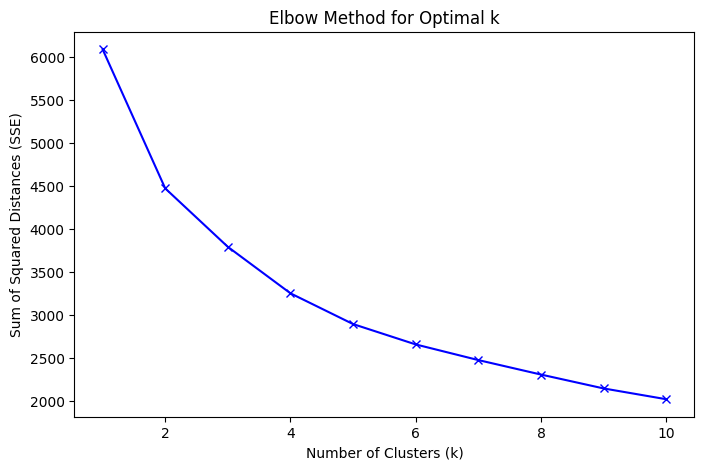

In [14]:
from sklearn.cluster import KMeans

# Use the Elbow Method to find the optimal k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse[k] = kmeans.inertia_

# Plot the SSE against k
plt.figure(figsize=(8, 5))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

Assuming the optimal number of clusters is 4 (you can decide based on the Elbow plot), apply K-Means clustering.

In [15]:
# Apply K-Means with k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_features)

### 5.4. Cluster Analysis
Analyze and interpret the clusters.

In [16]:
# Aggregate features by cluster for analysis
cluster_analysis = customer_data.groupby('cluster').mean(numeric_only=True).reset_index()


print('Cluster Analysis:')
print(cluster_analysis)

Cluster Analysis:
   cluster    client_id   total_amount  mean_amount  transaction_count  \
0        0  1010.852321  631076.298608    66.931576        9659.911392   
1        1   995.562319  366154.046464    37.493646       10078.971014   
2        2  1066.628743  934357.164072    45.979641       20963.443114   
3        3   986.861702  297680.100170    36.273045        8592.289362   

   average_credit_limit  current_age  
0          23529.884425    49.223629  
1          11478.076505    69.802899  
2          18484.231550    54.365269  
3          11395.955686    42.208511  


Visualize clusters using PCA for dimensionality reduction.

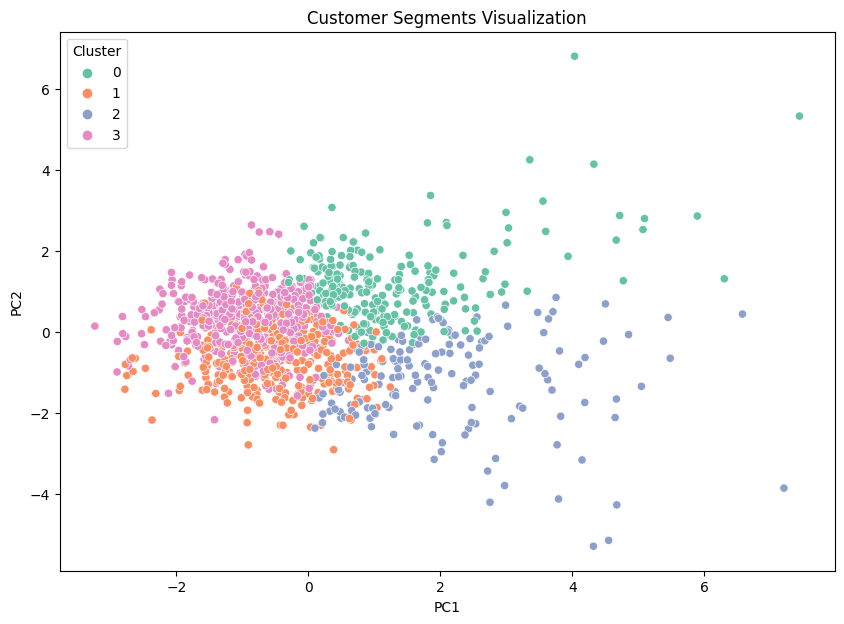

In [17]:
# Reduce to 2 components for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = customer_data['cluster']

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Customer Segments Visualization')
plt.show()

## 6. Identifying High-Value Customers
Define high-value customers based on certain criteria.

In [18]:
# Calculate thresholds for top 20%
amount_threshold = customer_data['total_amount'].quantile(0.80)
transaction_threshold = customer_data['transaction_count'].quantile(0.80)
credit_limit_threshold = customer_data['average_credit_limit'].quantile(0.80)



In [19]:
# Flag high-value customers
customer_data['is_high_value'] = np.where(
    (customer_data['total_amount'] >= amount_threshold) &
    (customer_data['transaction_count'] >= transaction_threshold) &
    (customer_data['average_credit_limit'] >= credit_limit_threshold),
    1, 0
)



In [20]:
# Number and percentage of high-value customers
num_high_value = customer_data['is_high_value'].sum()
percent_high_value = (num_high_value / customer_data.shape[0]) * 100
print(f'Number of High-Value Customers: {num_high_value}')
print(f'Percentage of High-Value Customers: {percent_high_value:.2f}%')

Number of High-Value Customers: 57
Percentage of High-Value Customers: 4.68%


Visualize the distribution of high-value customers across clusters.

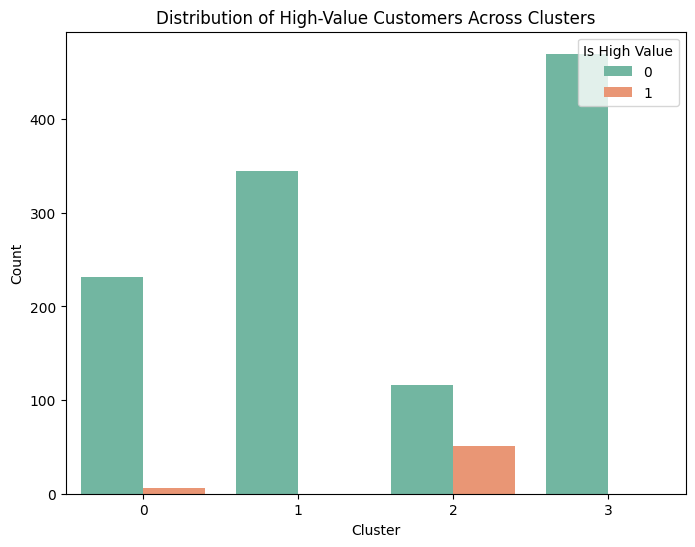

In [21]:
# Plot distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=customer_data, x='cluster', hue='is_high_value', palette='Set2')
plt.title('Distribution of High-Value Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Is High Value', loc='upper right')
plt.show()

## 7. Churn Prediction
### 7.1. Defining Churn
Define churn as customers who have not made any transactions in the last 180 days.

In [22]:
# Calculate the latest transaction date
latest_date = transactions_full_df['date'].max()



In [23]:
# Calculate days since last transaction for each customer
last_transaction_df = transactions_full_df.groupby('client_id')['date'].max().reset_index()
last_transaction_df['days_since_last_transaction'] = (latest_date - last_transaction_df['date']).dt.days



In [24]:
# Define churn status
last_transaction_df['is_churn'] = np.where(last_transaction_df['days_since_last_transaction'] > 180, 1, 0)



In [25]:
# Merge churn status into customer data
customer_churn_data = customer_data.merge(
    last_transaction_df[['client_id', 'is_churn']],
    on='client_id',
    how='left'
)

# Fill missing churn values with 0 (assuming they are active)
customer_churn_data['is_churn'] = customer_churn_data['is_churn'].fillna(0).astype(int)

### 7.2. Data Preparation
Prepare data for modeling.

In [26]:
# Features for modeling
model_features = [
    'total_amount',
    'mean_amount',
    'transaction_count',
    'average_credit_limit',
    'current_age',
    'gender',
    'card_brand',
    'card_type',
    'cluster'
]

# Target variable
target = 'is_churn'

# Encode categorical variables if not already encoded
# 'gender', 'card_brand', 'card_type' are categorical
label_encoders = {}
for col in ['gender', 'card_brand', 'card_type']:
    le = LabelEncoder()
    customer_churn_data[col] = le.fit_transform(customer_churn_data[col].astype(str))
    label_encoders[col] = le

Separate features and target variable.

In [27]:
X = customer_churn_data[model_features]
y = customer_churn_data[target]

### 7.3. Splitting Data into Training and Testing Sets
Split the data into training and testing sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 7.4. Building and Evaluating Models
#### 7.4.1. Random Forest Classifier


In [29]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [30]:
# Predict on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred_rf))

print('Confusion Matrix (Random Forest):')
print(confusion_matrix(y_test, y_pred_rf))

print('Accuracy (Random Forest):', accuracy_score(y_test, y_pred_rf))
print('ROC AUC Score (Random Forest):', roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1]))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       0.00      0.00      0.00         3

    accuracy                           0.99       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.98      0.99      0.98       244

Confusion Matrix (Random Forest):
[[241   0]
 [  3   0]]
Accuracy (Random Forest): 0.9877049180327869
ROC AUC Score (Random Forest): 0.743430152143845


### 7.4.2. XGBoost Classifier

In [31]:
# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb))

print('Confusion Matrix (XGBoost):')
print(confusion_matrix(y_test, y_pred_xgb))

print('Accuracy (XGBoost):', accuracy_score(y_test, y_pred_xgb))
print('ROC AUC Score (XGBoost):', roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:, 1]))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       0.00      0.00      0.00         3

    accuracy                           0.99       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.98      0.99      0.98       244

Confusion Matrix (XGBoost):
[[241   0]
 [  3   0]]
Accuracy (XGBoost): 0.9877049180327869
ROC AUC Score (XGBoost): 0.8824343015214384


#### 7.4.3. Feature Importance
Visualize the feature importance from the XGBoost model.

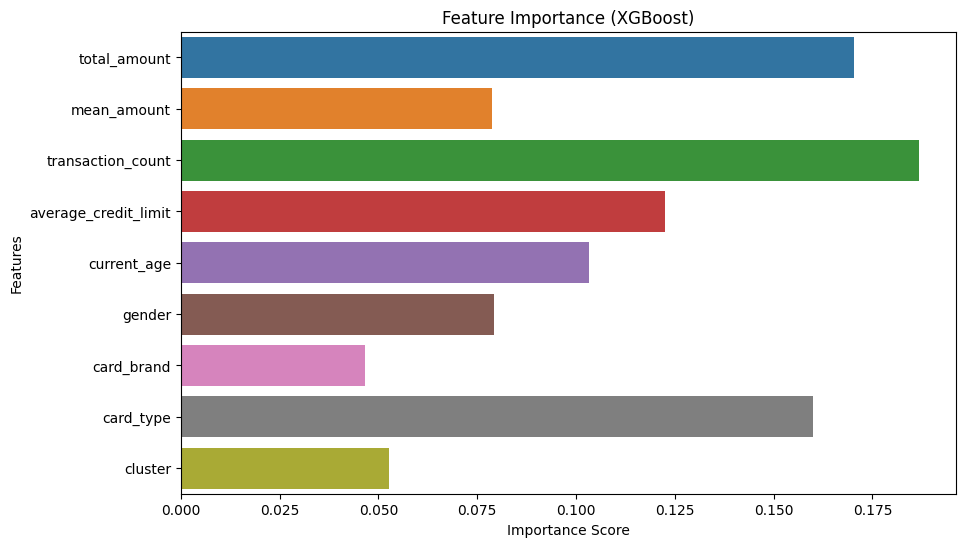

In [32]:
# Get feature importance
xgb_importance = xgb_classifier.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance, y=feature_names)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 8. Hyperparameter Tuning
Optimizing your machine learning models can significantly improve their performance. We'll use GridSearchCV to find the best hyperparameters for the Random Forest and XGBoost classifiers.

### 8.1. Random Forest Hyperparameter Tuning
#### 8.1.1. Import Necessary Libraries

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [35]:
rf_classifier = RandomForestClassifier(random_state=42)

In [36]:
grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=2
)

In [37]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='roc_auc', verbose=2)

In [38]:
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Use the best estimator to make predictions
best_rf = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)

# Evaluate the model
print('Random Forest Classification Report (After Tuning):')
print(classification_report(y_test, y_pred_rf_best))
print('Accuracy:', accuracy_score(y_test, y_pred_rf_best))
print('ROC AUC Score:', roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))

Best Parameters for Random Forest:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       0.00      0.00      0.00         3

    accuracy                           0.99       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.98      0.99      0.98       244

Accuracy: 0.9877049180327869
ROC AUC Score: 0.9031811894882434


### 8.2. XGBoost Hyperparameter Tuning

In [39]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [40]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [41]:
grid_search_xgb = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=2
)

In [42]:
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [43]:
print("Best Parameters for XGBoost:")
print(grid_search_xgb.best_params_)

# Use the best estimator to make predictions
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)

# Evaluate the model
print('XGBoost Classification Report (After Tuning):')
print(classification_report(y_test, y_pred_xgb_best))
print('Accuracy:', accuracy_score(y_test, y_pred_xgb_best))
print('ROC AUC Score:', roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

Best Parameters for XGBoost:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Classification Report (After Tuning):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       241
           1       0.00      0.00      0.00         3

    accuracy                           0.99       244
   macro avg       0.49      0.50      0.50       244
weighted avg       0.98      0.99      0.98       244

Accuracy: 0.9877049180327869
ROC AUC Score: 0.9239280774550483


## 9. Cross-Validation
Cross-validation provides a more robust estimate of the model's performance by evaluating it on multiple train-test splits.

#### 9.1. Implementing K-Fold Cross-Validation

In [44]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [45]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
rf_cv_scores = cross_val_score(
    best_rf,
    X,
    y,
    cv=kfold,
    scoring='roc_auc',
    n_jobs=-1
)

print(f'Random Forest Cross-Validation ROC AUC Scores: {rf_cv_scores}')
print(f'Average ROC AUC Score: {rf_cv_scores.mean():.4f}')

Random Forest Cross-Validation ROC AUC Scores: [0.91942149 0.76141079 0.83817427 0.92392808 0.98547718]
Average ROC AUC Score: 0.8857


In [47]:
xgb_cv_scores = cross_val_score(
    best_xgb,
    X,
    y,
    cv=kfold,
    scoring='roc_auc',
    n_jobs=-1
)

print(f'XGBoost Cross-Validation ROC AUC Scores: {xgb_cv_scores}')
print(f'Average ROC AUC Score: {xgb_cv_scores.mean():.4f}')

XGBoost Cross-Validation ROC AUC Scores: [0.63739669 0.7724758  0.76556017 0.92047026 0.98755187]
Average ROC AUC Score: 0.8167


## 10 Implementing DBSCAN Clustering for customer Segmentation
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is useful for discovering clusters of arbitrary shape and identifying outliers.

In [48]:
# 'scaled_features' from previous clustering

In [49]:
from sklearn.cluster import DBSCAN

 Determine Optimal Parameters
DBSCAN's main parameters are:


* eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
* min_samples: The number of samples in a neighborhood for a point to be considered a core point.


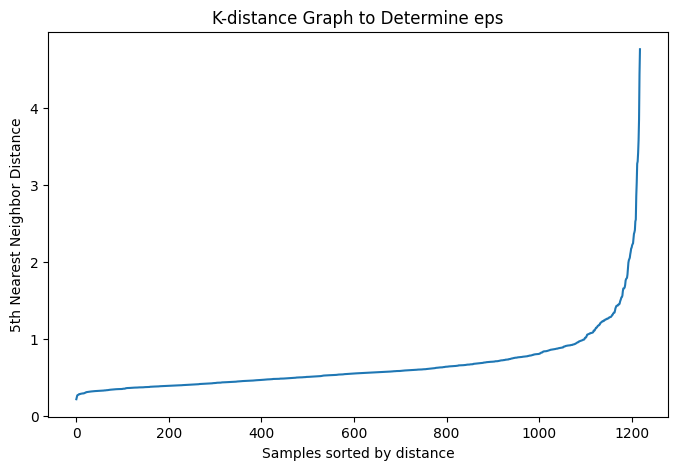

In [50]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)

# Sort the distances
distances = np.sort(distances[:, 4], axis=0)

# Plot the distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-distance Graph to Determine eps')
plt.xlabel('Samples sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()

In [51]:
# Assuming eps=0.5 and min_samples=5 (adjust based on your data)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Add labels to the customer_data DataFrame
customer_data['dbscan_cluster'] = dbscan_labels


In [52]:
# Check the number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 11
Estimated number of noise points: 557


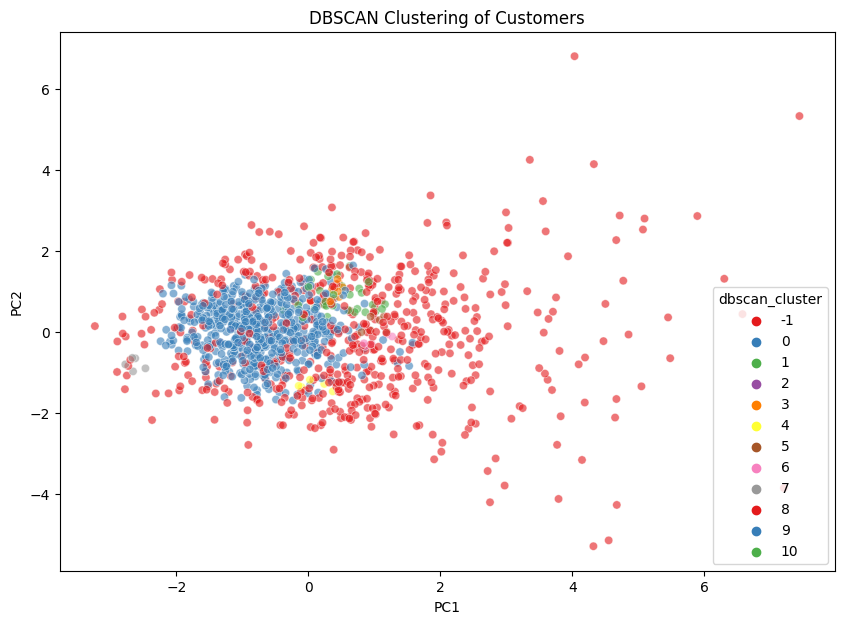

In [53]:
# Visualize clusters using PCA
principal_df['dbscan_cluster'] = dbscan_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=principal_df, x='PC1', y='PC2', hue='dbscan_cluster', palette='Set1', legend='full', alpha=0.6
)
plt.title('DBSCAN Clustering of Customers')
plt.show()

In [54]:
# Exclude noise points (-1)
dbscan_clusters = customer_data[customer_data['dbscan_cluster'] != -1]

# Group by clusters and calculate the mean for numeric columns
dbscan_cluster_analysis = dbscan_clusters.groupby('dbscan_cluster').mean(numeric_only=True).reset_index()

print('DBSCAN Cluster Analysis:')
print(dbscan_cluster_analysis)


DBSCAN Cluster Analysis:
    dbscan_cluster    client_id   total_amount  mean_amount  \
0                0   960.903614  328023.592978    37.419960   
1                1   878.500000  581993.337857    58.219907   
2                2   506.285714  237938.078571    40.676264   
3                3  1041.111111  401793.354444    54.132282   
4                4  1040.400000  508989.428000    33.106306   
5                5  1119.166667  641283.763333    53.503863   
6                6   967.800000  783250.374000    61.547060   
7                7  1216.800000   80799.746000    16.743658   
8                8  1136.714286  576667.661429    27.159489   
9                9  1104.200000  787010.090000    55.393354   
10              10   831.000000  468260.425000    72.684235   

    transaction_count  average_credit_limit  current_age   cluster  \
0         8972.905336          12208.553331    51.790017  2.175559   
1        10009.571429          14272.473460    41.642857  0.642857   
2       

## Visualizations Using Seaborn and Matplotlib

Churn Rate by Cluster

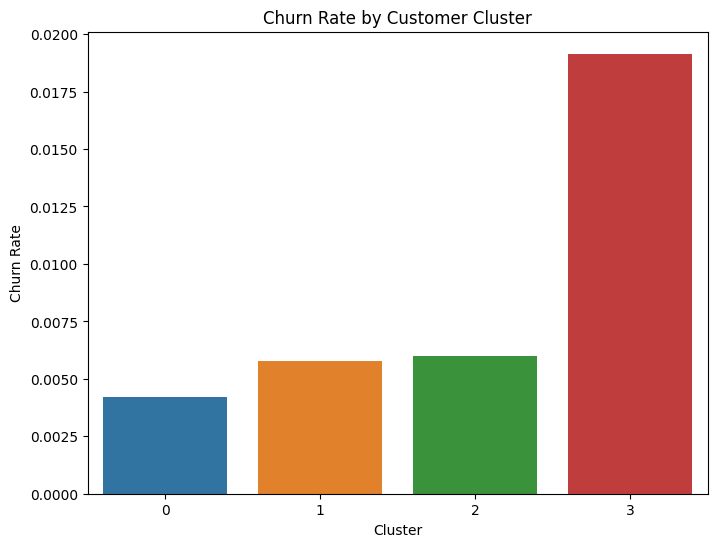

In [55]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=customer_churn_data, x='cluster', y='is_churn', estimator=np.mean, ci=None
)
plt.title('Churn Rate by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Churn Rate')
plt.show()

Heatmap of Feature Correlations

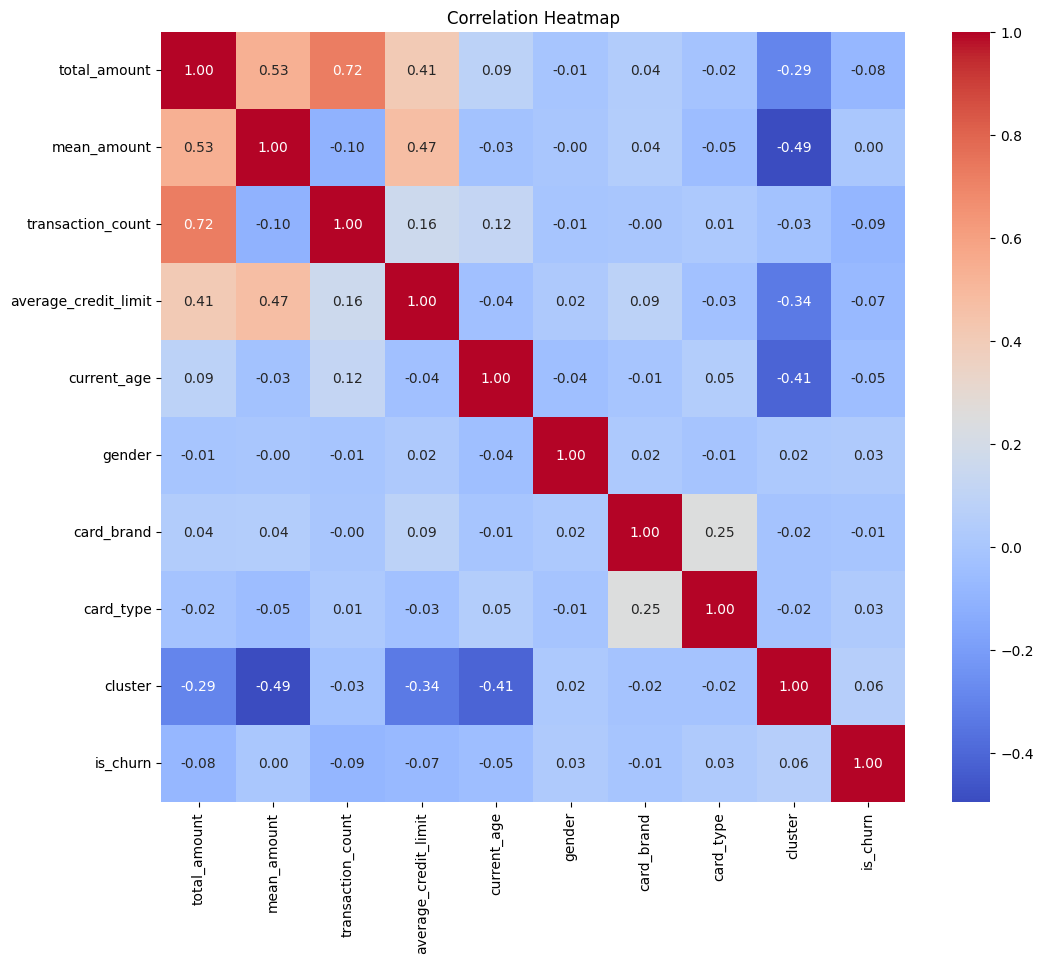

In [56]:
plt.figure(figsize=(12, 10))
corr = X.join(y).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Export Data for Power BI

In [57]:
import os
import joblib
import json
from datetime import datetime

print("Step 1: Creating directory structure...")

# Define base directory and subdirectories
base_dir = '/kaggle/working/business_intelligence'
directories = [
    f'{base_dir}/data',                    # For processed data files
    f'{base_dir}/models',                  # For saved models
    f'{base_dir}/analysis',                # For analysis results
    f'{base_dir}/segmentation',            # For clustering results
    f'{base_dir}/high_value_customers',    # For high-value customer analysis
    f'{base_dir}/churn_prediction'         # For churn prediction results
]

# Create directories
for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}")

Step 1: Creating directory structure...
Created directory: /kaggle/working/business_intelligence/data
Created directory: /kaggle/working/business_intelligence/models
Created directory: /kaggle/working/business_intelligence/analysis
Created directory: /kaggle/working/business_intelligence/segmentation
Created directory: /kaggle/working/business_intelligence/high_value_customers
Created directory: /kaggle/working/business_intelligence/churn_prediction


In [58]:
print("\nStep 2: Saving customer segmentation data...")

# 2.1 Save processed customer data
customer_data.to_csv(f'{base_dir}/data/customer_data.csv', index=False)
print("Saved customer data")

# 2.2 Save scaled features and clustering results
customer_features = pd.DataFrame(scaled_features, columns=numerical_features)
customer_features['cluster'] = customer_data['cluster']
customer_features.to_csv(f'{base_dir}/segmentation/customer_features.csv', index=False)
print("Saved customer features")

# 2.3 Save cluster analysis
cluster_analysis.to_csv(f'{base_dir}/segmentation/cluster_analysis.csv', index=False)
print("Saved cluster analysis")

# 2.4 Save clustering model and scaler
joblib.dump(kmeans, f'{base_dir}/models/kmeans_model.keras')
joblib.dump(scaler, f'{base_dir}/models/feature_scaler.keras')
print("Saved clustering model and scaler")

# 2.5 Save PCA results for visualization
pca_results = pd.DataFrame({
    'PC1': principal_df['PC1'],
    'PC2': principal_df['PC2'],
    'Cluster': principal_df['Cluster']
})
pca_results.to_csv(f'{base_dir}/segmentation/pca_visualization.csv', index=False)
print("Saved PCA results")


Step 2: Saving customer segmentation data...
Saved customer data
Saved customer features
Saved cluster analysis
Saved clustering model and scaler
Saved PCA results


In [59]:
print("\nStep 3: Saving high-value customer analysis...")

# 3.1 Save high-value customer thresholds and metrics
high_value_analysis = pd.DataFrame({
    'metric': [
        'Amount Threshold',
        'Transaction Threshold',
        'Credit Limit Threshold',
        'Number of High-Value Customers',
        'Percentage of High-Value Customers'
    ],
    'value': [
        amount_threshold,
        transaction_threshold,
        credit_limit_threshold,
        num_high_value,
        percent_high_value
    ]
})
high_value_analysis.to_csv(f'{base_dir}/high_value_customers/high_value_metrics.csv', index=False)
print("Saved high-value metrics")

# 3.2 Save list of high-value customers
high_value_customers = customer_data[customer_data['is_high_value'] == 1]
high_value_customers.to_csv(f'{base_dir}/high_value_customers/high_value_customers.csv', index=False)
print("Saved high-value customer list")

# 3.3 Save high-value distribution by cluster
high_value_distribution = customer_data.groupby('cluster')['is_high_value'].agg(['count', 'sum', 'mean'])
high_value_distribution.to_csv(f'{base_dir}/high_value_customers/cluster_distribution.csv')
print("Saved high-value distribution by cluster")


Step 3: Saving high-value customer analysis...
Saved high-value metrics
Saved high-value customer list
Saved high-value distribution by cluster


In [60]:
print("\nStep 3: Saving high-value customer analysis...")

# 3.1 Save high-value customer thresholds and metrics
high_value_analysis = pd.DataFrame({
    'metric': [
        'Amount Threshold',
        'Transaction Threshold',
        'Credit Limit Threshold',
        'Number of High-Value Customers',
        'Percentage of High-Value Customers'
    ],
    'value': [
        amount_threshold,
        transaction_threshold,
        credit_limit_threshold,
        num_high_value,
        percent_high_value
    ]
})
high_value_analysis.to_csv(f'{base_dir}/high_value_customers/high_value_metrics.csv', index=False)
print("Saved high-value metrics")

# 3.2 Save list of high-value customers
high_value_customers = customer_data[customer_data['is_high_value'] == 1]
high_value_customers.to_csv(f'{base_dir}/high_value_customers/high_value_customers.csv', index=False)
print("Saved high-value customer list")

# 3.3 Save high-value distribution by cluster
high_value_distribution = customer_data.groupby('cluster')['is_high_value'].agg(['count', 'sum', 'mean'])
high_value_distribution.to_csv(f'{base_dir}/high_value_customers/cluster_distribution.csv')
print("Saved high-value distribution by cluster")


Step 3: Saving high-value customer analysis...
Saved high-value metrics
Saved high-value customer list
Saved high-value distribution by cluster


In [61]:
print("\nStep 4: Saving churn prediction data and models...")

# 4.1 Save churn data
customer_churn_data.to_csv(f'{base_dir}/churn_prediction/customer_churn_data.csv', index=False)
print("Saved churn data")

# 4.2 Save best models
joblib.dump(best_rf, f'{base_dir}/models/random_forest_best.keras')
joblib.dump(best_xgb, f'{base_dir}/models/xgboost_best.keras')
print("Saved best models")

# 4.3 Save model parameters
model_params = {
    'random_forest_best_params': grid_search_rf.best_params_,
    'xgboost_best_params': grid_search_xgb.best_params_
}
with open(f'{base_dir}/models/model_parameters.json', 'w') as f:
    json.dump(model_params, f, indent=4)
print("Saved model parameters")

# 4.4 Save model performance metrics
model_performance = pd.DataFrame({
    'model': ['Random Forest', 'XGBoost'],
    'accuracy': [
        accuracy_score(y_test, y_pred_rf_best),
        accuracy_score(y_test, y_pred_xgb_best)
    ],
    'roc_auc': [
        roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
    ]
})
model_performance.to_csv(f'{base_dir}/churn_prediction/model_performance.csv', index=False)
print("Saved model performance metrics")


Step 4: Saving churn prediction data and models...
Saved churn data
Saved best models
Saved model parameters
Saved model performance metrics


In [62]:
print("\nStep 5: Saving feature importance analysis...")

# 5.1 Save feature importance for both models
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_rf': best_rf.feature_importances_,
    'importance_xgb': best_xgb.feature_importances_
})
feature_importance.to_csv(f'{base_dir}/analysis/feature_importance.csv', index=False)
print("Saved feature importance analysis")

# 5.2 Save label encoders
joblib.dump(label_encoders, f'{base_dir}/models/label_encoders.keras')
print("Saved label encoders")


Step 5: Saving feature importance analysis...
Saved feature importance analysis
Saved label encoders


In [63]:
print("\nStep 6: Saving summary statistics and analysis...")

# 6.1 Create comprehensive summary
summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_summary': {
        'total_customers': len(customer_data),
        'total_transactions': len(transactions_full_df),
        'date_range': {
            'start': transactions_full_df['date'].min().strftime('%Y-%m-%d'),
            'end': transactions_full_df['date'].max().strftime('%Y-%m-%d')
        }
    },
    'clustering_summary': {
        'number_of_clusters': optimal_k,
        'features_used': numerical_features,
        'cluster_sizes': customer_data['cluster'].value_counts().to_dict()
    },
    'high_value_summary': {
        'number_of_high_value_customers': int(num_high_value),
        'percentage_of_high_value_customers': float(percent_high_value)
    },
    'churn_summary': {
        'churn_rate': float((customer_churn_data['is_churn'] == 1).mean() * 100),
        'model_performance': {
            'random_forest_accuracy': float(accuracy_score(y_test, y_pred_rf_best)),
            'xgboost_accuracy': float(accuracy_score(y_test, y_pred_xgb_best))
        }
    }
}

# 6.2 Save summary
with open(f'{base_dir}/analysis/summary_report.json', 'w') as f:
    json.dump(summary, f, indent=4)
print("Saved summary report")


Step 6: Saving summary statistics and analysis...
Saved summary report


In [64]:
print("\nStep 7: Creating README file...")

readme_content = """
Business Intelligence & Customer Analytics Results
==============================================

Directory Structure:
------------------
/data/
    - customer_data.csv: Processed customer data
    - customer_features.csv: Features used for analysis

/segmentation/
    - customer_features.csv: Clustering features and results
    - cluster_analysis.csv: Detailed cluster analysis
    - pca_visualization.csv: PCA results for visualization

/high_value_customers/
    - high_value_metrics.csv: High-value customer thresholds and metrics
    - high_value_customers.csv: List of high-value customers
    - cluster_distribution.csv: Distribution across clusters

/churn_prediction/
    - customer_churn_data.csv: Churn prediction data
    - model_performance.csv: Model performance metrics

/models/
    - kmeans_model.pkl: Clustering model
    - random_forest_best.pkl: Best Random Forest model
    - xgboost_best.pkl: Best XGBoost model
    - feature_scaler.pkl: Feature scaler
    - label_encoders.pkl: Label encoders
    - model_parameters.json: Model parameters

/analysis/
    - feature_importance.csv: Feature importance analysis
    - summary_report.json: Comprehensive analysis summary

Usage for Power BI:
-----------------
1. Import CSV files from respective folders
2. Create relationships using common identifiers
3. Use the data to create:
   - Customer segmentation dashboards
   - High-value customer analysis
   - Churn prediction monitoring
   - Feature importance visualizations
"""

with open(f'{base_dir}/README.txt', 'w') as f:
    f.write(readme_content)
print("Created README file")


Step 7: Creating README file...
Created README file


In [65]:
print("\nStep 8: Verifying saved files...")

def verify_file(filepath):
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"✓ {filepath} (Size: {size/1024:.2f} KB)")
        # Verify file is not empty
        if size == 0:
            print(f"  Warning: File is empty!")
        return True
    else:
        print(f"✗ {filepath} not found")
        return False

# List all files to verify
files_to_verify = [
    f'{base_dir}/data/customer_data.csv',
    f'{base_dir}/segmentation/customer_features.csv',
    f'{base_dir}/segmentation/cluster_analysis.csv',
    f'{base_dir}/high_value_customers/high_value_metrics.csv',
    f'{base_dir}/high_value_customers/high_value_customers.csv',
    f'{base_dir}/churn_prediction/customer_churn_data.csv',
    f'{base_dir}/churn_prediction/model_performance.csv',
    f'{base_dir}/models/kmeans_model.keras',
    f'{base_dir}/models/random_forest_best.keras',
    f'{base_dir}/models/xgboost_best.keras',
    f'{base_dir}/models/feature_scaler.keras',
    f'{base_dir}/models/label_encoders.keras',
    f'{base_dir}/analysis/feature_importance.csv',
    f'{base_dir}/analysis/summary_report.json',
    f'{base_dir}/README.txt'
]

# Verify each file
all_files_present = all(verify_file(f) for f in files_to_verify)

if all_files_present:
    print("\nAll files saved successfully!")
else:
    print("\nWarning: Some files are missing!")


Step 8: Verifying saved files...
✓ /kaggle/working/business_intelligence/data/customer_data.csv (Size: 102.88 KB)
✓ /kaggle/working/business_intelligence/segmentation/customer_features.csv (Size: 119.95 KB)
✓ /kaggle/working/business_intelligence/segmentation/cluster_analysis.csv (Size: 0.53 KB)
✓ /kaggle/working/business_intelligence/high_value_customers/high_value_metrics.csv (Size: 0.20 KB)
✓ /kaggle/working/business_intelligence/high_value_customers/high_value_customers.csv (Size: 5.05 KB)
✓ /kaggle/working/business_intelligence/churn_prediction/customer_churn_data.csv (Size: 83.83 KB)
✓ /kaggle/working/business_intelligence/churn_prediction/model_performance.csv (Size: 0.12 KB)
✓ /kaggle/working/business_intelligence/models/kmeans_model.keras (Size: 5.63 KB)
✓ /kaggle/working/business_intelligence/models/random_forest_best.keras (Size: 336.09 KB)
✓ /kaggle/working/business_intelligence/models/xgboost_best.keras (Size: 100.10 KB)
✓ /kaggle/working/business_intelligence/models/feat